In [1]:
cd ../

/Users/joepalmo/Desktop/cfa/SDU-preproc


In [2]:
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
from astropy.io import ascii
import os

# open source module found for converting MJD/JD to DateTimes
import jdutil as jd

# Ben's module -- THANKS BEN
import LCtools

# my preprocessing module
from preproc import *

import glob

In [3]:
# specify path to the lightcurve and spectrum
lc_path = "supernovae/SN2011fe/SN2011fe_LC"
spec_path = "supernovae/SN2011fe/SN2011fe_spec_+1"

# object name (or abbreviation)
n = "SN_Ia"

# resample length for time-sorted LC purposes
resample_len = '1d'

# LC Data Munging

In [4]:
# read in the text file
lc = pd.read_csv(lc_path, sep = ",")
# choose only V-band measurements
lc = lc[lc['band']=='V']
# remove upper limits
lc = lc[lc['upperlimit']=='F']
# choose only the source that we want ------ SHOULD WE DO THIS?
# listed as source #18 on the website -- Munari et al. https://ui.adsabs.harvard.edu/abs/2013NewA...20...30M/abstract
lc = lc[lc['source']=='2013NewA...20...30M']
# choose columns and rename
lc = lc[['time', 'magnitude']].rename(columns={'time':'mjd', 'magnitude':'mag'})

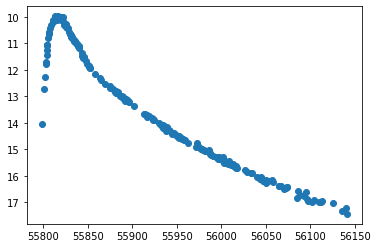

In [5]:
#raw data
plt.scatter(lc['mjd'], lc['mag'])
plt.gca().invert_yaxis()

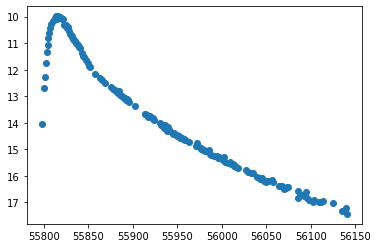

In [6]:
#resampled data
time_preproc_lc = LC_timesort_preproc(lc, resample_len=resample_len)
plt.scatter(time_preproc_lc['Modified Julian Day'], time_preproc_lc['Magnitude'])
plt.gca().invert_yaxis()

In [7]:
# number of days video covers
len(time_preproc_lc)

343

In [8]:
# The average data play rate determined empirically from sonoUno is about 
# 8.5 data rows played per second. Therefore:
print("Estimated video time of "+ str(len(time_preproc_lc) / 8.5), "s")

Estimated video time of 40.35294117647059 s


# Spectra Data Munging

In [14]:
lc

,mjd,mag
timestamp,,
2011-08-25 21:23:45.599992,55798.8915,14.033
2011-08-27 20:03:41.759985,55800.8359,12.704
2011-08-28 19:45:24.479999,55801.8232,12.265
2011-08-29 19:38:29.760019,55802.8184,11.791
2011-08-29 19:47:08.159983,55802.8244,11.682
...,...,...
2012-07-05 20:55:06.240016,56113.8716,16.968
2012-07-17 22:05:31.200001,56125.9205,17.045
2012-07-27 23:07:00.480010,56135.9632,17.319


In [16]:
# Time of peak ->
lc[lc['mag']==lc.mag.min()]['mjd']

timestamp
2011-09-09 18:42:54.720012    55813.7798
Name: mjd, dtype: float64

In [17]:
# Download the spectrum closest to this date from this paper:
# https://ui.adsabs.harvard.edu/abs/2013A%26A...554A..27P/abstract

# specify path to the spectrum
spec_path = "supernovae/SN2011fe/SN2011fe_spec_+7"
# read in the text file
spec = pd.read_csv(spec_path, sep = ",")
# choose columns and rename
spec = spec[['wavelength', 'flux']]

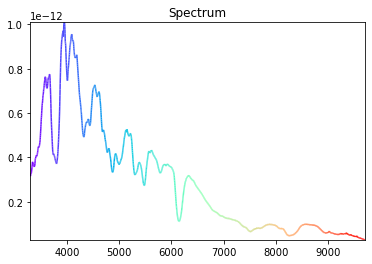

In [18]:
#raw data
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
fig, ax = plt.subplots()
x,y = spec['wavelength'], spec['flux']
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
# Create a continuous norm to map from data points to colors
norm = plt.Normalize(x.min(), x.max())
lc = LineCollection(segments, cmap='rainbow', norm=norm)
lc.set_array(x)
ax.add_collection(lc)
ax.set_title('Spectrum')
plt.show()

In [28]:
preproc_spec = spectra_preproc(spec, bins=wavelength_bins())

In [29]:
# rescale to remove scientific notation
preproc_spec['Flux'] = preproc_spec['Flux'] * 1e12

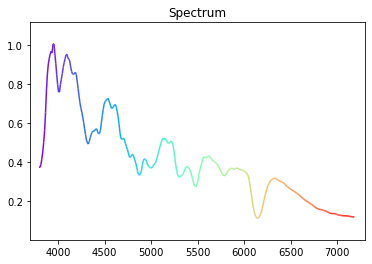

In [30]:
#preprocessed
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
fig, ax = plt.subplots()
x,y = preproc_spec['Wavelength'], preproc_spec['Flux']
ax.set_xlim(3700, 7300)
ax.set_ylim(np.nanmin(y)-0.5*np.nanstd(y), np.nanmax(y)+0.5*np.nanstd(y))
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
# Create a continuous norm to map from data points to colors
norm = plt.Normalize(x.min(), x.max())
lc = LineCollection(segments, cmap='rainbow', norm=norm)
lc.set_array(x)
ax.add_collection(lc)
ax.set_title('Spectrum')
plt.show()

# Export Preprocessed Files

In [31]:
#create output directory
outdir = 'preproc/{}/'.format(n)
if not os.path.exists(outdir):
    os.makedirs(outdir)   

In [32]:
#save preprocessed files
time_preproc_lc.to_csv("preproc/{}/{}_LC_timesort.csv".format(n,n), index=False)
preproc_spec.to_csv("preproc/{}/{}_spec.csv".format(n,n), index=False)